# Readme
Tут два файла истории EURUSD 1 за 2016 год часовой тик. 2016й полньій год можна использовать для обучения, а часть 2017-го для валидации, я включил 2.5 месяца в 2017й.

Данньіе в файлах идут как Local time, Open,High, Low,Close, Volume

Не знаю насколько тьі знаком с такими данньіми. Коротко, то Open - цена в начале тика данньіх, Close - в конце периода, ну и High Low внутренние колебания наибольшая и наименьшая цена
В принципе все 4, и также Volume, обьем продаж за етот период, важньі. Но для простотьі можем пока что брать только Open цену для обучального набора примеров

Тут Gnuplot скрипт для примера чтобьі рисовать Candlesticks и етих данньіх

Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее
Таким образом learning set будет иметь 8754 примера

# Contents:
## [Data Wrangling](#DWr)
- Import packages and read the data
- [Plot the data](#PlotData)

## [Formulate the ML Model](#Model)
- Split input data into [batches](#Batches) (learning windows)
- The Olexander's [moving average model](#MAverage) (TODO)
- Make a standard [ARIMA based model](#ARIMA) (TODO)
- Make a simple [LSTM network](#LSTM) (TODO)
- Combine [LSTM and ARIMA](#LSTM+ARIMA) (TODO)
- Improve the LSTM by applying a [wavelet transformation](#Wavelet) (TODO)

## Data Wrangling<a id='DWr'></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read the input files
EURUSD_1H_2016_df = pd.read_table('EURUSD_1H_2016.txt',sep=',')

In [4]:
# Preview the dataframe
EURUSD_1H_2016_df

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
...,...,...,...,...,...,...
8778,31.12.2016 19:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8779,31.12.2016 20:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8780,31.12.2016 21:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8781,31.12.2016 22:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0


In [7]:
# check for nan values 
EURUSD_1H_2016_df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [10]:
type(EURUSD_1H_2016_df)

pandas.core.frame.DataFrame

### Plot the data<a id='PlotData'></a>

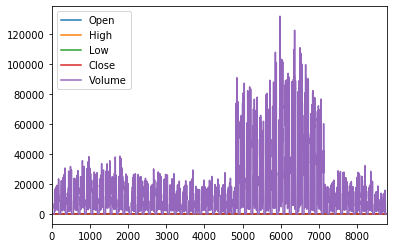

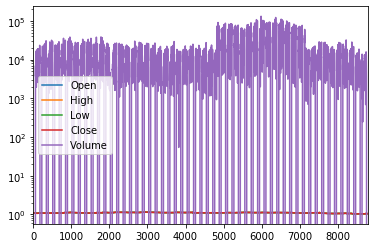

In [15]:
# Plot everything as a line
EURUSD_1H_2016_df.plot.line();
# Plot in log scale
EURUSD_1H_2016_df.plot.line(logy=True);

**`Volume` is much larger than anything else.**

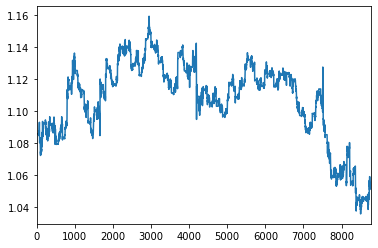

In [20]:
# Plot only 'Open'
EURUSD_1H_2016_df.Open.plot.line();

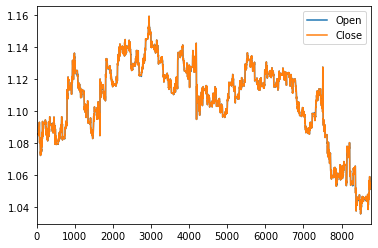

In [26]:
# Plot 'Open' and 'Close'
EURUSD_1H_2016_df.plot.line(y={'Open','Close'});

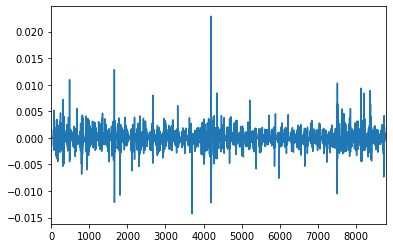

In [28]:
# Plot the difference of 'Open' and 'Close'
(EURUSD_1H_2016_df.Open - EURUSD_1H_2016_df.Close).plot.line();

**`Open` almost coincides with `Close`.**

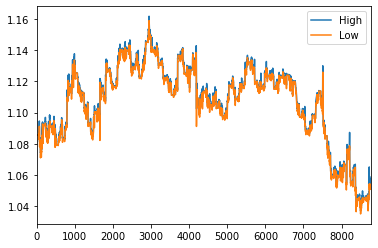

In [30]:
# Plot 'High' and 'Low'
EURUSD_1H_2016_df.plot.line(y={'High','Low'});

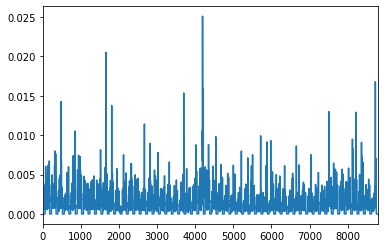

In [31]:
# Plot the difference of 'High' and 'Low'
(EURUSD_1H_2016_df.High - EURUSD_1H_2016_df.Low).plot.line();

## Formlate the ML Model<a id='Model'></a>

### Split input data into batches (learning windows)<a id='Batches'></a>

In [33]:
# Get 'Open'
EURUSD_1H_2016_df.Open

0       1.08564
1       1.08564
2       1.08564
3       1.08564
4       1.08564
         ...   
8778    1.05150
8779    1.05150
8780    1.05150
8781    1.05150
8782    1.05150
Name: Open, Length: 8783, dtype: float64

In [39]:
# Get 'Open' by index
print('Open[0]:\n',EURUSD_1H_2016_df.Open[0])
print('Open[8782]:\n',EURUSD_1H_2016_df.Open[8782])
# Get a slice
print('Open[100:110]:\n',EURUSD_1H_2016_df.Open[100:110])

Open[0]:
 1.08564
Open[8782]:
 1.0515
Open[100:110]:
 100    1.07559
101    1.07516
102    1.07421
103    1.07391
104    1.07216
105    1.07422
106    1.07455
107    1.07338
108    1.07436
109    1.07500
Name: Open, dtype: float64


In [50]:
# Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, 
# и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее.
# Таким образом learning set будет иметь 8754 примера
def get_slices(data, point, run_win=24, fwd_win=5):
    
    # Input:
        # data: a column in a data frame to slice,
        # point: index of the entering point for the slice, 
        # run_win: backward looking window,
        # fwd_win: forward looking window
        
    # Output:
        # run: backward slice
        # fwd: forward slice
    start = point - run_win 
    stop  = point + fwd_win
    
    run = data[start:point+1]
    fwd = data[      point+1:stop]
    
    return run, fwd

In [51]:
# Test `get_slices`
data = EURUSD_1H_2016_df
get_slices(data,42,fwd_win=3)

(                 Local time     Open     High      Low    Close  Volume
 18  01.01.2016 18:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 19  01.01.2016 19:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 20  01.01.2016 20:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 21  01.01.2016 21:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 22  01.01.2016 22:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 23  01.01.2016 23:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 24  02.01.2016 00:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 25  02.01.2016 01:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 26  02.01.2016 02:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 27  02.01.2016 03:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 28  02.01.2016 04:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 29  02.01.2016 05:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 30  02.01.2016 06:00:00.000  1.08564  1.08564  1.0

### The Olexander's moving average model<a id='MAverage'></a> (TODO)

### Make a standard ARIMA based model<a id='ARIMA'></a> (TODO)

### Make a simple LSTM network<a id='LSTM'></a> (TODO)

### Combine LSTM and ARIMA<a id='LSTM+ARIMA'></a> (TODO)
- [Demand Forecasting for Platelet Usage: from Univariate Time Series to Multivariate Models](https://arxiv.org/pdf/2101.02305.pdf)

### Improve the LSTM by applying a wavelet transformation<a id='Wavelet'></a> (TODO)
- A blog about [Wavelets](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/?fbclid=IwAR2w32L-CDuMkAzF5NrmqmsWZu8NHmgW-bt8Em1124AQ58r7AMHam9MQdFU)